# Import thư viện

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet
import itertools
import utils
import seaborn as sns

c:\Users\ASUS\.conda\envs\time_series_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



# Đọc dữ liệu


In [2]:
df_full  = pd.read_csv('full_data.csv')

In [3]:
df_full.head()

,Unnamed: 0,date,total_usage,is_holiday,temperature,weekday,fill_zeros_usage,new_total_usage,new_total_usage_lag6,new_total_usage_lag7,new_total_usage_lag14,new_total_usage_lag21
0,21,2022-01-22,2.05,False,23.16,5,2.05,2255.0,1408.0,2101.0,2035.0,1496.0
1,22,2022-01-23,1.32,False,23.47,6,1.32,1452.0,4686.0,1408.0,1474.0,1177.0
2,23,2022-01-24,4.35,False,22.95,0,4.35,4785.0,3674.0,4686.0,4686.0,1463.0
3,24,2022-01-25,3.81,False,22.95,1,3.81,4191.0,3267.0,3674.0,4664.0,4037.0
4,25,2022-01-26,3.89,False,22.69,2,2.97,3267.0,3960.0,3267.0,4026.0,4191.0


# Lựa chọn dữ liệu để xây dựng mô hình

In [4]:
df_selected  = df_full.loc[:, ['date', 'is_holiday', 'temperature', 'new_total_usage', 'weekday']]

In [5]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899 entries, 0 to 898
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             899 non-null    object 
 1   is_holiday       899 non-null    bool   
 2   temperature      899 non-null    float64
 3   new_total_usage  899 non-null    float64
 4   weekday          899 non-null    int64  
dtypes: bool(1), float64(2), int64(1), object(1)
memory usage: 29.1+ KB


## Nhận xét:
- Các cột không có dữ liệu trống, có thể sử dụng để train model

# Chuẩn bị dữ liệu

In [6]:
df_selected['date'] = pd.to_datetime(df_full['date'])

In [7]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899 entries, 0 to 898
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             899 non-null    datetime64[ns]
 1   is_holiday       899 non-null    bool          
 2   temperature      899 non-null    float64       
 3   new_total_usage  899 non-null    float64       
 4   weekday          899 non-null    int64         
dtypes: bool(1), datetime64[ns](1), float64(2), int64(1)
memory usage: 29.1 KB


In [8]:
df_final = df_selected.rename({'date':'ds','new_total_usage':'y','temperature':'temp'}, axis='columns')

In [9]:
df_final.head()

,ds,is_holiday,temp,y,weekday
0,2022-01-22,False,23.16,2255.0,5
1,2022-01-23,False,23.47,1452.0,6
2,2022-01-24,False,22.95,4785.0,0
3,2022-01-25,False,22.95,4191.0,1
4,2022-01-26,False,22.69,3267.0,2


# Chia tập train test

In [10]:
train=df_final[(df_final['ds'] <= '2024-01-01')]
test=df_final[(df_final['ds'] > '2024-01-01')]

In [11]:
train.shape

(710, 5)

In [12]:
test.shape

(189, 5)

# Tạo model

In [13]:
model= Prophet(interval_width=0.95,yearly_seasonality=True)

In [14]:
# Add the regressors
model.add_regressor('temp')
model.add_regressor('weekday')
model.add_regressor('is_holiday')

# Sử dụng cross validation để đánh giá model

In [16]:
from prophet.diagnostics import cross_validation, performance_metrics

In [135]:
cv_results = cross_validation(model=model, horizon='5 days')

  0%|          | 0/136 [00:00<?, ?it/s]10:36:30 - cmdstanpy - INFO - Chain [1] start processing
10:36:30 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 1/136 [00:01<02:34,  1.14s/it]10:36:30 - cmdstanpy - INFO - Chain [1] start processing
10:36:30 - cmdstanpy - INFO - Chain [1] done processing
  1%|▏         | 2/136 [00:01<01:19,  1.68it/s]10:36:31 - cmdstanpy - INFO - Chain [1] start processing
10:36:31 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 3/136 [00:01<00:57,  2.33it/s]10:36:31 - cmdstanpy - INFO - Chain [1] start processing
10:36:31 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 4/136 [00:01<00:45,  2.93it/s]10:36:31 - cmdstanpy - INFO - Chain [1] start processing
10:36:31 - cmdstanpy - INFO - Chain [1] done processing
  4%|▎         | 5/136 [00:02<00:38,  3.41it/s]10:36:31 - cmdstanpy - INFO - Chain [1] start processing
10:36:31 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 6/136 [00:02<00:33,  3.83it/s]1

In [136]:
df_p = performance_metrics(cv_results)

In [137]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 12:00:00,2.733801e+06,1653.421039,1359.222641,1.019819,0.247647,0.516747,0.750000
1,1 days 00:00:00,1.784255e+06,1335.760162,1096.470180,0.479162,0.216947,0.370976,0.808824
2,1 days 12:00:00,2.128088e+06,1458.796856,1239.019800,0.628611,0.280834,0.447558,0.838235
3,2 days 00:00:00,2.180777e+06,1476.745283,1161.832889,0.580224,0.199010,0.395544,0.808824
4,2 days 12:00:00,1.848480e+06,1359.588025,1087.350316,0.528411,0.230555,0.381947,0.823529
5,3 days 00:00:00,2.573362e+06,1604.170174,1305.957485,0.959721,0.249383,0.497185,0.764706
6,3 days 12:00:00,1.819345e+06,1348.830888,1094.727531,0.483969,0.220969,0.369274,0.823529
7,4 days 00:00:00,2.183121e+06,1477.538877,1263.953037,0.641752,0.266785,0.475770,0.823529
8,4 days 12:00:00,2.212925e+06,1487.590380,1158.360973,0.581260,0.217215,0.387101,0.808824
9,5 days 00:00:00,1.940329e+06,1392.956774,1111.662830,0.536418,0.242331,0.379604,0.808824


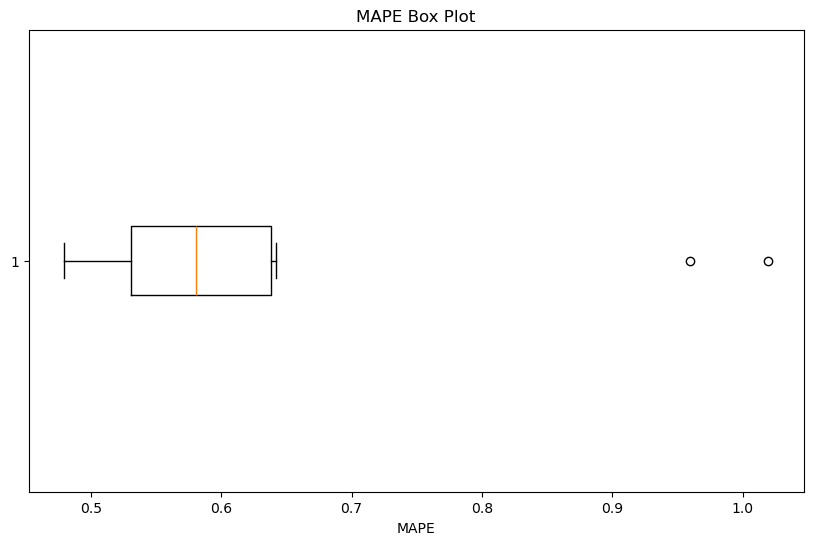

In [138]:
# Plot MAPE with a box plot
plt.figure(figsize=(10, 6))
plt.boxplot(df_p['mape'], vert=False)
plt.title('MAPE Box Plot')
plt.xlabel('MAPE')
plt.show()

## Nhận xét
- MAPE trung bình ở khoảng 60%

# Hiệu chỉnh hyper parameter

In [156]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
    }

In [157]:
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the MAPEs for each params here

In [158]:
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('temp')
    m.add_regressor('weekday')
    m.add_regressor('is_holiday')
    m.fit(train)  # Fit model with given params
    df_cv = cross_validation(m, horizon='5 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mapes.append(df_p['mape'].mean())

10:49:05 - cmdstanpy - INFO - Chain [1] start processing
10:49:05 - cmdstanpy - INFO - Chain [1] done processing
10:49:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:49:05 - cmdstanpy - INFO - Chain [1] start processing
10:49:06 - cmdstanpy - INFO - Chain [1] done processing
10:50:10 - cmdstanpy - INFO - Chain [1] start processing
10:50:11 - cmdstanpy - INFO - Chain [1] done processing
10:50:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:50:11 - cmdstanpy - INFO - Chain [1] start processing
10:50:11 - cmdstanpy - INFO - Chain [1] done processing
10:51:15 - cmdstanpy - INFO - Chain [1] start processing
10:51:15 - cmdstanpy - INFO - Chain [1] done processing
10:51:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

In [160]:
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes

In [161]:
# Find the index of the minimum MAPE value
best_index = np.argmin(mapes)

# Extract the best parameters and corresponding MAPE
best_params = all_params[best_index]
best_mape = mapes[best_index]

# Print the best parameters and corresponding MAPE
print("Best Parameters:", best_params)
print("MAPE at Best Parameters:", best_mape)

Best Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
MAPE at Best Parameters: 0.4354258073242746


## Nhận xét
- Sau khi thực hiện GridSearch để tìm hyperparams tối ưu thì MAPE giảm còn 43%
- Best Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


# Cross-validation sau khi có được hyper parameter tối ưu

In [14]:
test_cross_validation_model = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=1, holidays_prior_scale=10, seasonality_mode='multiplicative')

In [17]:
test_cross_validation_model.add_regressor('temp')
test_cross_validation_model.add_regressor('weekday')
test_cross_validation_model.add_regressor('is_holiday')
test_cross_validation_model.fit(train)  # Fit model with given params

08:15:41 - cmdstanpy - INFO - Chain [1] start processing
08:15:41 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
from prophet.diagnostics import cross_validation, performance_metrics
cv_after = cross_validation(model=test_cross_validation_model, horizon='5 days')

  0%|          | 0/276 [00:00<?, ?it/s]08:15:44 - cmdstanpy - INFO - Chain [1] start processing
08:15:45 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/276 [00:00<01:20,  3.41it/s]08:15:45 - cmdstanpy - INFO - Chain [1] start processing
08:15:45 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 2/276 [00:00<01:13,  3.75it/s]08:15:45 - cmdstanpy - INFO - Chain [1] start processing
08:15:45 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 3/276 [00:00<01:18,  3.46it/s]08:15:45 - cmdstanpy - INFO - Chain [1] start processing
08:15:46 - cmdstanpy - INFO - Chain [1] done processing
  1%|▏         | 4/276 [00:01<01:26,  3.14it/s]08:15:46 - cmdstanpy - INFO - Chain [1] start processing
08:15:46 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 5/276 [00:01<01:34,  2.87it/s]08:15:46 - cmdstanpy - INFO - Chain [1] start processing
08:15:46 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 6/276 [00:01<01:34,  2.87it/s]0

In [20]:
df_cv = performance_metrics(cv_after)

In [25]:
df_cv

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 12:00:00,1.767483e+06,1329.467192,955.221343,0.603611,0.175580,0.320327,0.608696
1,1 days 00:00:00,1.184026e+06,1088.129493,798.251580,0.366989,0.154593,0.259874,0.666667
2,1 days 12:00:00,1.435202e+06,1197.999189,885.034935,0.393214,0.169180,0.302110,0.659420
3,2 days 00:00:00,1.436923e+06,1198.717150,887.818441,0.413418,0.175920,0.279077,0.637681
4,2 days 12:00:00,1.323130e+06,1150.273822,835.844055,0.373331,0.152954,0.292564,0.659420
5,3 days 00:00:00,1.757228e+06,1325.604742,957.130574,0.597165,0.189069,0.320295,0.594203
6,3 days 12:00:00,1.284454e+06,1133.337651,846.593059,0.383919,0.156542,0.274079,0.623188
7,4 days 00:00:00,1.519153e+06,1232.539411,916.978585,0.404265,0.178190,0.316354,0.630435
8,4 days 12:00:00,1.512808e+06,1229.962750,912.875458,0.422429,0.198943,0.287631,0.630435
9,5 days 00:00:00,1.440952e+06,1200.396643,883.386349,0.395918,0.164178,0.307721,0.644928


In [26]:
df_cv['mape'].mean()

np.float64(0.4354258073242746)